## Лабораторная работа №1
### Конечномерная оптимизация, градиентные методы

Запрограммировать GD модификацию, выбрать персонально 2 функции из книжки или scikit.

Их визуализировать, реализовать sgd, sgd+LR schedule.

Запрограммировать 1 моментный метод и 1 адаптивный.

ДОП БАЛЛ: запрогать анимацию того как метод шагает по точкам на ландшафте (гифку например).

In [ ]:
from typing import Tuple, Mapping

import numpy as np
from matplotlib import pyplot as plt
import sklearn

In [ ]:
def do_plot_fnc(f: Mapping, name: str):
    x = y = np.arange(-15.0, 15.0, 0.05)
    X, Y = np.meshgrid(x, y)
    Z = f(X,Y)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y,Z, cmap = 'Spectral')
    ax.set_title(name, fontsize=16)

In [ ]:
def do_plot_with_gd(f:Mapping, name: str, history: list, gl_min_x=0,gl_min_y=0,gl_min_z=0, arange_x = -15.0, arange_y = 15.0, arange_step = 0.05):
    x = y = np.arange(arange_x, arange_y, arange_step)
    X, Y = np.meshgrid(x, y)
    Z = f(X,Y)
    fig = plt.figure(figsize=(10,10))
    sp = fig.add_subplot(projection='3d')
    sp.plot_wireframe(X,Y,Z, cmap = 'Spectral')
    sp.set_title(name, fontsize=16)
    sp.view_init(70, 45)
    sp.scatter(history[0][0], history[0][1], history[0][2],linewidths=5, color='g', alpha=1, label="Начальная точка")
    sp.scatter(p_x, p_y, p_z, linewidths  = 5 , color='r', alpha = 1, label ='Расчетный глобальный минимум')
    sp.scatter(gl_min_x, gl_min_y, gl_min_z, linewidths  = 7 , color='b', alpha = 1, label ='Глобальный минимум')
    sp.legend(fontsize=10, loc='lower right')
    sp.plot3D(np.linspace(p_x, p_x, 2), np.linspace(p_y, p_y, 2),np.linspace(p_z, 20, 2), 'red')
    for i in range(len(history)-1):
        sp.plot3D(np.linspace(history[i][0], history[i+1][0], 4), np.linspace(history[i][1], history[i+1][1], 4), np.linspace(history[i][2], history[i+1][2], 4), 'black')

In [ ]:
distances = [[],[],[]]

#### Тестовые функции

##### Функция трехгорбого верблюда
$$ {\displaystyle f(x,y)=2x^{2}-1.05x^{4}+{\frac {x^{6}}{6}}+xy+y^{2}} $$
Глобальный минимум
$$ {\displaystyle f(0,0)=0} $$
Метод поиска
$$ {\displaystyle -5\leq x,y\leq 5} $$

In [ ]:
def test_func_Camel(x: np.ndarray, y:np.ndarray) -> np.float64:   
    return 2 * x**2 - 1.05 * x**4 + 1/6 * x**6 + x * y + y**2

def test_func_Camel_dx(x: np.ndarray, y:np.ndarray) -> np.float64:
    return 4 * x - 4.2 * x**3 + x**5 + y

def test_func_Camel_dy(x: np.ndarray, y:np.ndarray) -> np.float64:
    return x + 2 * y

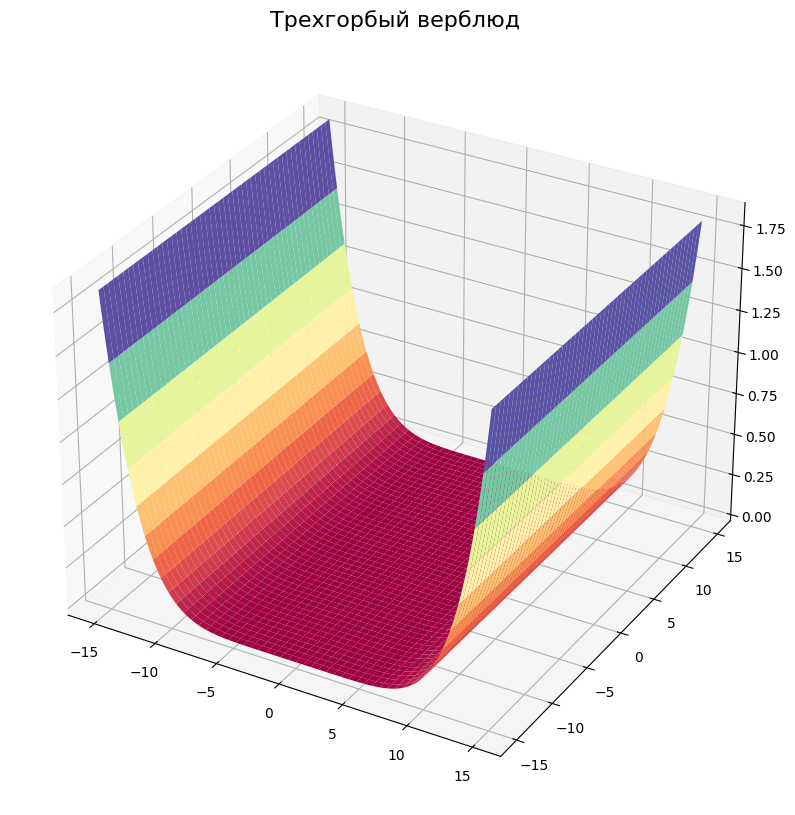

In [ ]:
do_plot_fnc(test_func_Camel, "Трехгорбый верблюд")

##### Функция Изома
$$ {\displaystyle f(x,y)=-\cos \left(x\right)\cos \left(y\right)\exp \left(-\left(\left(x-\pi \right)^{2}+\left(y-\pi \right)^{2}\right)\right)} $$
Глобальный минимум
$$ {\displaystyle f(\pi ,\pi )=-1} $$
Метод поиска
$$ {\displaystyle -100\leq x,y\leq 100} $$

In [ ]:
def test_func_Izom(x: np.ndarray, y:np.ndarray) -> np.float64:   
    return -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

def test_func_Izom_dx(x: np.ndarray, y:np.ndarray) -> np.float64:  
    return np.exp(-x**2-y**2-2*(np.pi)**2)*(np.cos(y)*np.exp(2*np.pi*x+2*np.pi*y)*np.sin(x)+(2*np.exp(2*np.pi*y)*np.cos(y)*x-2*np.pi*np.exp(2*np.pi*y)*np.cos(y))*np.exp(2*np.pi*x)*np.cos(x))

def test_func_Izom_dy(x: np.ndarray, y:np.ndarray) -> np.float64:
    return np.exp(-y**2-x**2-2*(np.pi)**2)*(np.cos(x)*np.exp(2*np.pi*y+2*np.pi*x)*np.sin(y)+(2*np.exp(2*np.pi*x)*np.cos(x)*y-2*np.pi*np.exp(2*np.pi*x)*np.cos(x))*np.exp(2*np.pi*y)*np.cos(y))

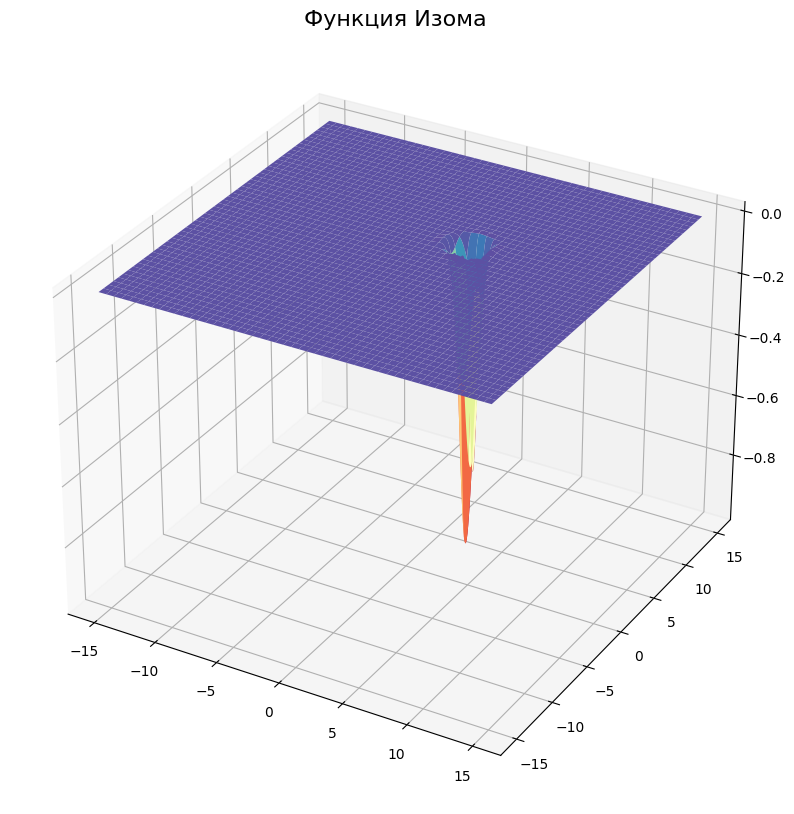

In [ ]:
do_plot_fnc(test_func_Izom, "Функция Изома")

##### Функция Била
$$ {\displaystyle f(x,y)=\left(1.5-x+xy\right)^{2}+\left(2.25-x+xy^{2}\right)^{2}} $$
Глобальный минимум:
$$ {\displaystyle f(3,0.5)=0} $$
Метод поиска:
$$ {\displaystyle -4.5\leq x,y\leq 4.5} $$

In [ ]:
def test_func_Bil(x: np.ndarray, y:np.ndarray) -> np.longdouble:
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2

def test_func_Bil_dx(x: np.ndarray, y:np.ndarray) -> np.longdouble:
    return (4 * y**4 - 4 * y**2 - 8*y + 8)*x * 0.5 + 4.5 *y**2 + 3 * y - 7.5

def test_func_Bil_dy(x: np.ndarray, y:np.ndarray) -> np.longdouble:
    return 4 * x**2 * y**3 + (9*x - 2*x**2)*y - 2 * x**2 + 3 * x

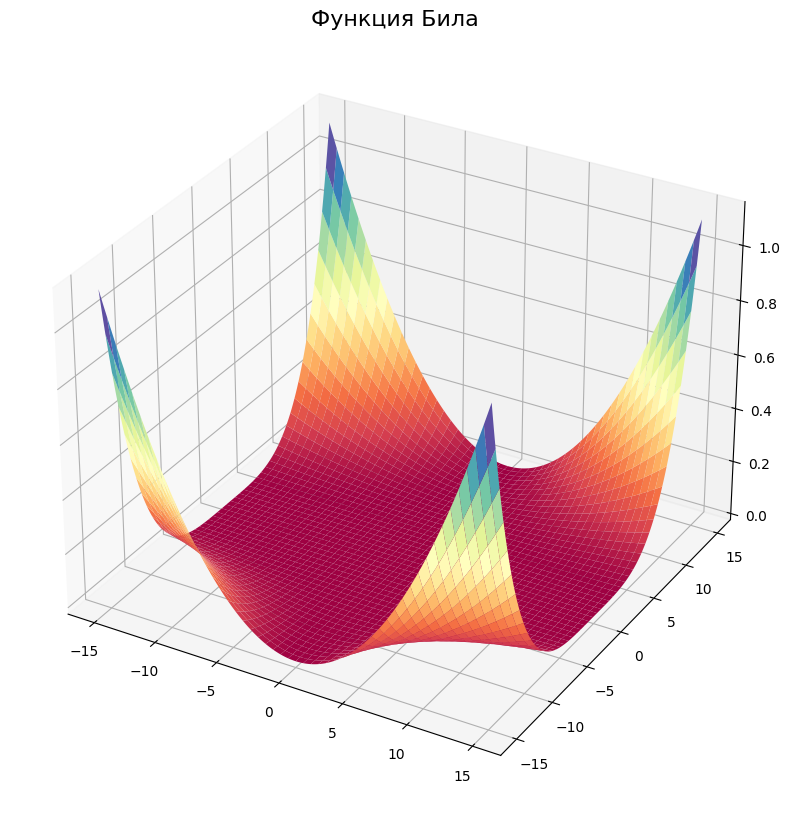

In [ ]:
do_plot_fnc(test_func_Bil, "Функция Била")

In [ ]:
def my_gd(f: Mapping, dfdx: Mapping, dfdy: Mapping, x0: np.ndarray, lr: float = 0.001, T: int = 10000)-> Tuple [np.ndarray, np.ndarray, np.float32]:
    """
    Реализация градиентного спуска
    
    Args:
        f(Mapping) -> функционал для оптимизации
        df(Mapping) -> градиент оптимизирующего функционала (dx,dy)
        x0(np.ndarray) -> стартовая точка
        lr(float) -> скорость обучения
        T(int) -> количество итераций
    
    Returns:
        x, y, результат функции от этих x и y
    
    """
    
    x_old = x0[0]
    y_old = x0[1]
    
    for _ in range(T):
        x_new = x_old - lr * dfdx(x_old, y_old)
        y_new = y_old - lr * dfdy(x_old, y_old)
        
        x_old = x_new
        y_old = y_new
        history.append([x_old.copy(), y_old.copy(), f(x_old, y_old)])
    return x_new, y_new, f(x_new, y_new)

Градиентный спуск
Начальная точка: x0 = 2, y0 = 5
Точка глобального минимума(расчетная): xt = -1.7475523478512982 , yt = 0.8737761936317952
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 0.29863844223685876 

Точка глобального минимума: x=0, y=0
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  1.9538229308302872


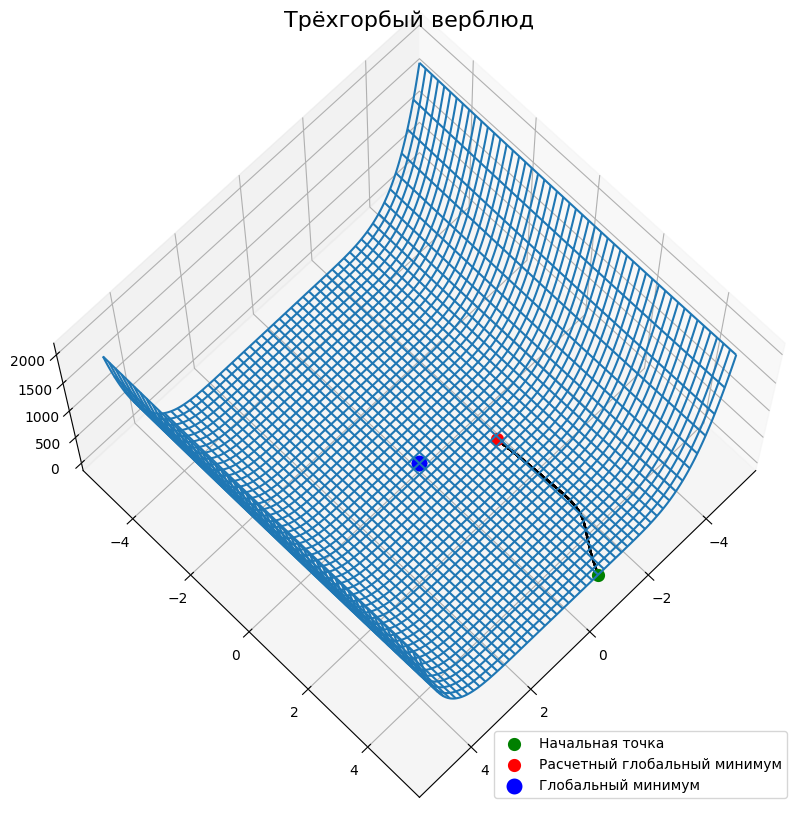

In [ ]:
history = list()
p_x,p_y,p_z = my_gd(test_func_Camel, test_func_Camel_dx, test_func_Camel_dy, np.array([-1,5]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(2,5))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(0,0))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt((p_x**2-0)+(p_y**2-0))
distances[0].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Camel, 'Трёхгорбый верблюд', history, arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 1, y0 = 10
Точка глобального минимума(расчетная): xt = 3.1415926535904575 , yt = 3.1415926535904575
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = -1.0 

Точка глобального минимума: x=3.141592653589793, y=3.141592653589793
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  2.8894423588611656e-06


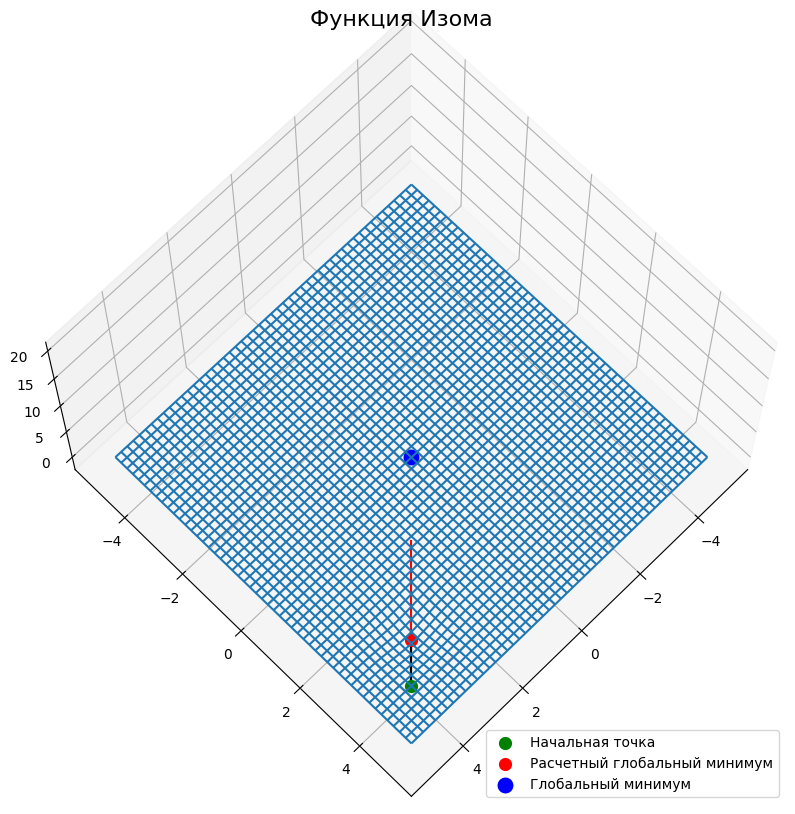

In [ ]:
history = list()
p_x,p_y,p_z = my_gd(test_func_Izom, test_func_Izom_dx, test_func_Izom_dy, np.array([4,4]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(1,10))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(np.pi,np.pi))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[1].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Izom, 'Функция Изома', history,arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 2, y0 = 0
Точка глобального минимума(расчетная): xt = 2.7465843132768795 , yt = 0.4412299190832519
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 0.0026587182189245877 

Точка глобального минимума: x=3, y=0.5
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  3.4642170213117245


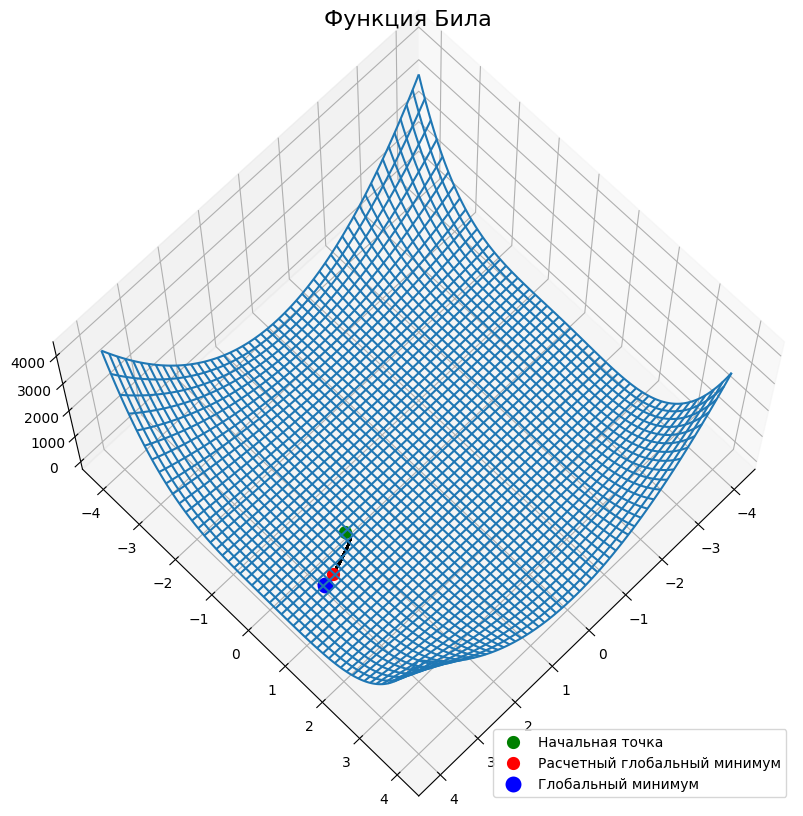

In [ ]:
history = list()
p_x,p_y,p_z = my_gd(test_func_Bil, test_func_Bil_dx, test_func_Bil_dy, np.array([2, 0]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(2,0))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(3,0.5))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[2].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Bil, 'Функция Била', history, 3, 0.5, 0, arange_x=-4, arange_y=4, arange_step=0.01)

### GD + LRS

In [ ]:
def my_gd_lrs(f: Mapping, dfdx: Mapping, dfdy: Mapping, x0: np.ndarray, lr: float = 0.001, lrs:int = 10, coefficient:float = 0.05, T: int = 10000)-> Tuple [np.ndarray, np.ndarray, np.float32]:
    """
    Реализация градиентного спуска + LRS
    
    Args:
        f(Mapping) -> функционал для оптимизации
        df(Mapping) -> градиент оптимизирующего функционала (dx,dy)
        x0(np.ndarray) -> стартовая точка
        lr(float) -> скорость обучения
        lrs(int) -> на какой итерации изменится скорость обучения
        coefficient(float) -> коэффициент изменения скорости обучения путем умножения
        T(int) -> количество итераций
    
    Returns:
        x, y, результат функции от этих x и y
    
    """
    
    x_old = x0[0]
    y_old = x0[1]
    
    for i in range(T):
        if i == lrs:
            lr *= coefficient
        x_new = x_old - lr * dfdx(x_old, y_old)
        y_new = y_old - lr * dfdy(x_old, y_old)
        
        x_old = x_new
        y_old = y_new
        history.append([x_old.copy(), y_old.copy(), f(x_old, y_old)])
    return x_new, y_new, f(x_new, y_new)

Градиентный спуск
Начальная точка: x0 = -1, y0 = 5
Точка глобального минимума(расчетная): xt = -1.852180991942093 , yt = 2.365788619295755
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 2.447933760067703 

Точка глобального минимума: x=0, y=0
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  3.0045848661838312


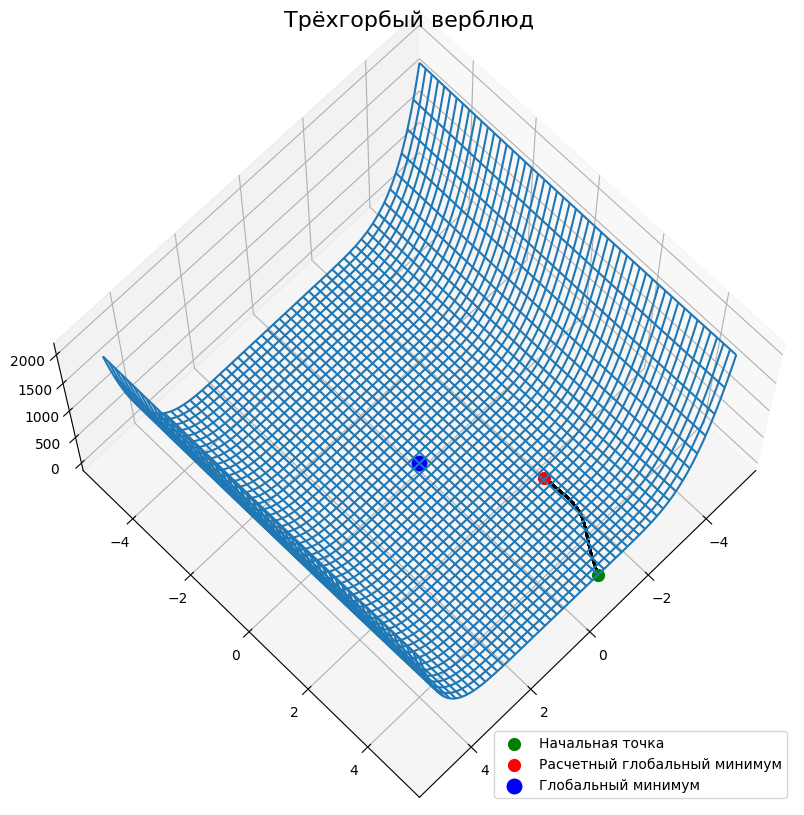

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_lrs(test_func_Camel, test_func_Camel_dx, test_func_Camel_dy, np.array([-1,5]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(-1,5))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(0,0))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt((p_x**2-0)+(p_y**2-0))
distances[0].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Camel, 'Трёхгорбый верблюд', history, arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 4, y0 = 4
Точка глобального минимума(расчетная): xt = 3.7965577069146867 , yt = 3.7965577069146867
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = -0.2666954261490618 

Точка глобального минимума: x=3.141592653589793, y=3.141592653589793
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  3.0147125968635704


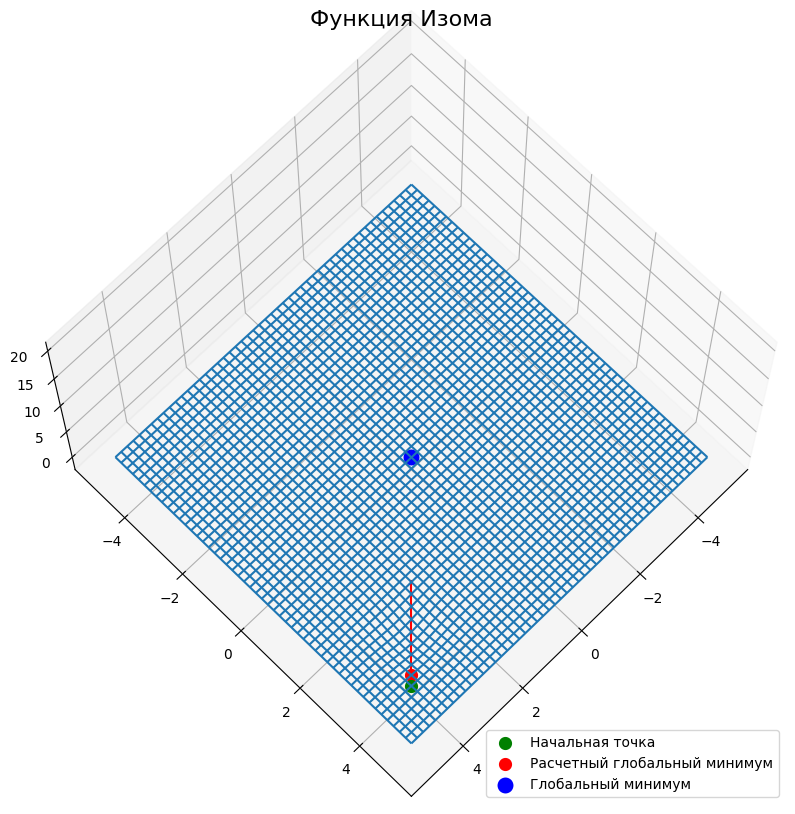

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_lrs(test_func_Izom, test_func_Izom_dx, test_func_Izom_dy, np.array([4,4]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(4,4))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(np.pi,np.pi))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[1].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Izom, 'Функция Изома', history,arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 3, y0 = -1
Точка глобального минимума(расчетная): xt = 2.42757321315716 , yt = 0.3467523751461413
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 0.020429844287257765 

Точка глобального минимума: x=3, y=0.5
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  3.7048427614773405


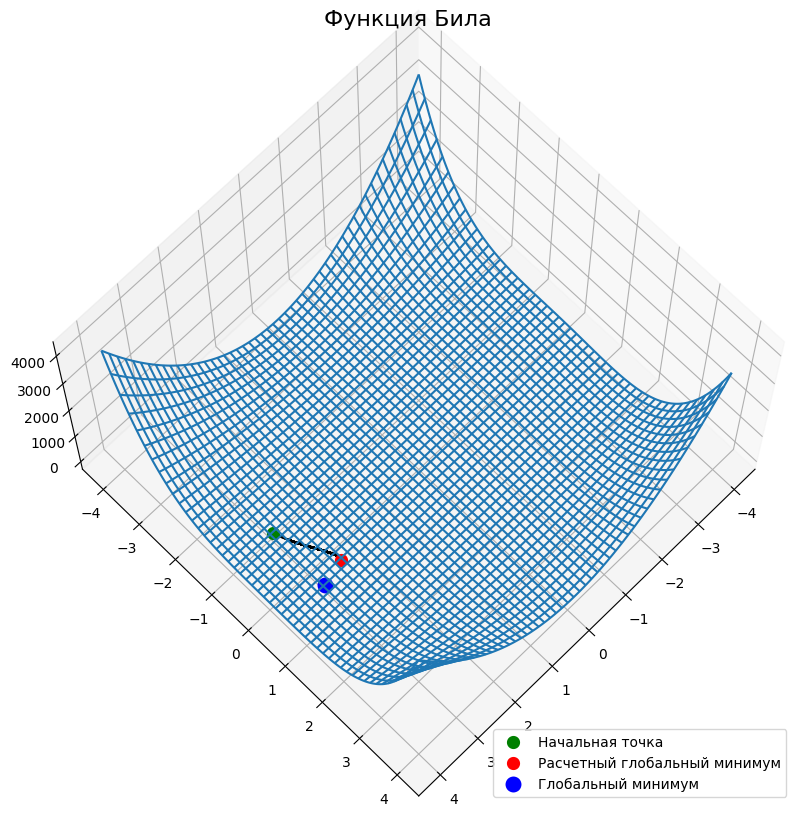

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_lrs(test_func_Bil, test_func_Bil_dx, test_func_Bil_dy, np.array([3, -1]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(3,-1))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(3,0.5))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[2].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Bil, 'Функция Била', history, 3, 0.5, 0, arange_x=-4, arange_y=4, arange_step=0.01)

### Моментный метод

In [ ]:
def my_gd_moment(f: Mapping, dfdx: Mapping, dfdy: Mapping, x0: np.ndarray, lr: float = 0.001, lrs:int = 10, coefficient:float = 0.05, momentum_component:float = 0.1, T: int = 10000)-> Tuple [np.ndarray, np.ndarray, np.float32]:
    """
    Реализация градиентного спуска (моментный)
    
    Args:
        f(Mapping) -> функционал для оптимизации
        df(Mapping) -> градиент оптимизирующего функционала (dx,dy)
        x0(np.ndarray) -> стартовая точка
        lr(float) -> скорость обучения
        lrs(int) -> на какой итерации изменится скорость обучения
        coefficient(float) -> коэффициент изменения скорости обучения путем умножения
        momentum_component(float) -> составляющая импульса
        T(int) -> количество итераций
    
    Returns:
        x, y, результат функции от этих x и y
    
    """
    
    x_old = x0[0]
    y_old = x0[1]
    
    for i in range(T):
        if i == lrs:
            lr *= coefficient
        x_new = x_old * momentum_component - lr * dfdx(x_old, y_old)
        y_new = y_old * momentum_component - lr * dfdy(x_old, y_old)
        
        x_old = x_new
        y_old = y_new
        history.append([x_old.copy(), y_old.copy(), f(x_old, y_old)])
    return x_new, y_new, f(x_new, y_new)

Градиентный спуск
Начальная точка: x0 = -1, y0 = 5
Точка глобального минимума(расчетная): xt = 0.0 , yt = 0.0
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 0.0 

Точка глобального минимума: x=0, y=0
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  0.0


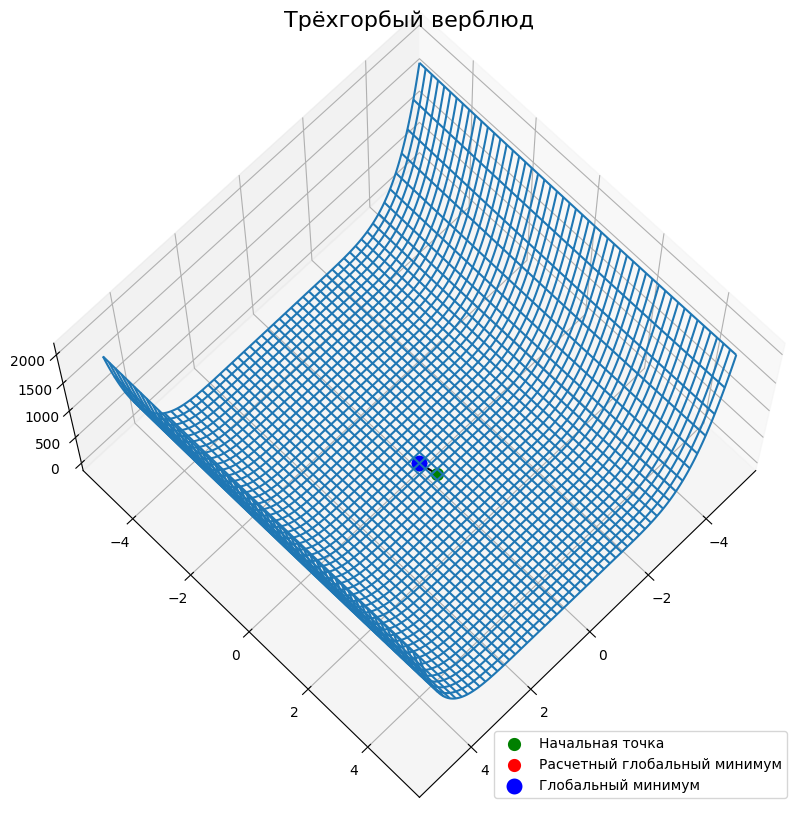

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_moment(test_func_Camel, test_func_Camel_dx, test_func_Camel_dy, np.array([-1,5]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(-1,5))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(0,0))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt((p_x**2-0)+(p_y**2-0))
distances[0].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Camel, 'Трёхгорбый верблюд', history, arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 4, y0 = 4
Точка глобального минимума(расчетная): xt = 9.338516776767466e-13 , yt = 9.338516776767466e-13
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = -2.6752879911056366e-09 

Точка глобального минимума: x=3.141592653589793, y=3.141592653589793
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  4.442882938158366


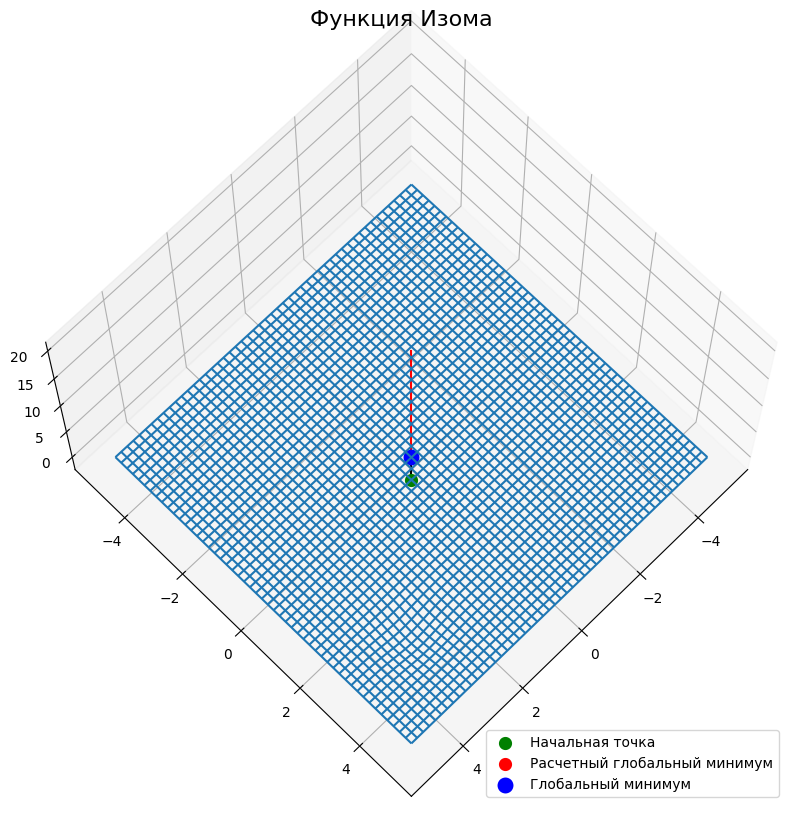

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_moment(test_func_Izom, test_func_Izom_dx, test_func_Izom_dy, np.array([4,4]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(4,4))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(np.pi,np.pi))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[1].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Izom, 'Функция Изома', history,arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 3, y0 = -1
Точка глобального минимума(расчетная): xt = 0.00041657410620492594 , yt = -6.940972169101733e-08
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 7.309376041184716 

Точка глобального минимума: x=3, y=0.5
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  4.44288291862893


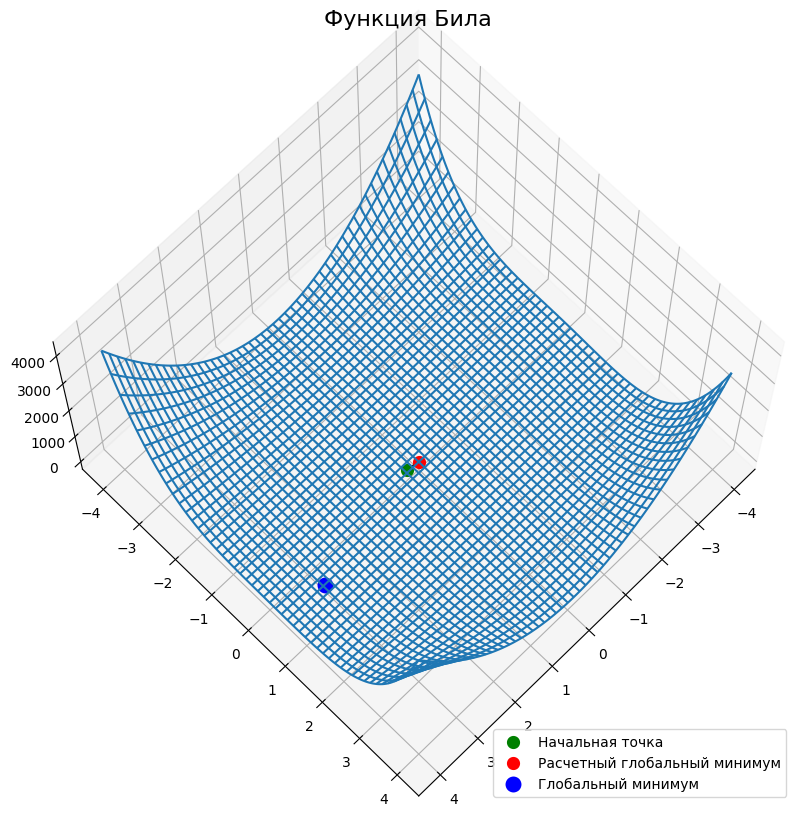

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_moment(test_func_Bil, test_func_Bil_dx, test_func_Bil_dy, np.array([3, -1]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(3,-1))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(3,0.5))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[2].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Bil, 'Функция Била', history, 3, 0.5, 0, arange_x=-4, arange_y=4, arange_step=0.01)

### Adagrad

In [ ]:
def my_gd_Adagrad(f: Mapping, dfdx: Mapping, dfdy: Mapping, x0: np.ndarray, lr: float = 0.001, lrs:int = 10, coefficient:float = 0.05, momentum_component:float = 0.1, T: int = 10000)-> Tuple [np.ndarray, np.ndarray, np.float32]:
    """
    Реализация градиентного спуска (Adagrad)
    
    Args:
        f(Mapping) -> функционал для оптимизации
        df(Mapping) -> градиент оптимизирующего функционала (dx,dy)
        x0(np.ndarray) -> стартовая точка
        lr(float) -> скорость обучения
        lrs(int) -> на какой итерации изменится скорость обучения
        coefficient(float) -> коэффициент изменения скорости обучения путем умножения
        momentum_component(float) -> составляющая импульса
        T(int) -> количество итераций
    
    Returns:
        x, y, результат функции от этих x и y
    
    """
    
    x_old = x0[0]
    y_old = x0[1]
    
    sum_grad_square = [(lr * dfdx(x_old, y_old))**2, (lr * dfdy(x_old, y_old))**2]
    for i in range(T):
        if i == lrs:
            lr *= coefficient
        x_new = x_old * momentum_component - (lr / np.sqrt(sum_grad_square[0])) * dfdx(x_old, y_old)
        y_new = y_old * momentum_component - (lr / np.sqrt(sum_grad_square[1])) * dfdy(x_old, y_old)
        
        sum_grad_square[0] += (lr * dfdx(x_old, y_old))**2
        sum_grad_square[1] += (lr * dfdy(x_old, y_old))**2
        
        x_old = x_new
        y_old = y_new
        history.append([x_old.copy(), y_old.copy(), f(x_old, y_old)])
    return x_new, y_new, f(x_new, y_new)

Градиентный спуск
Начальная точка: x0 = -1, y0 = 5
Точка глобального минимума(расчетная): xt = 0.0 , yt = 0.0
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 0.0 

Точка глобального минимума: x=0, y=0
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  0.0


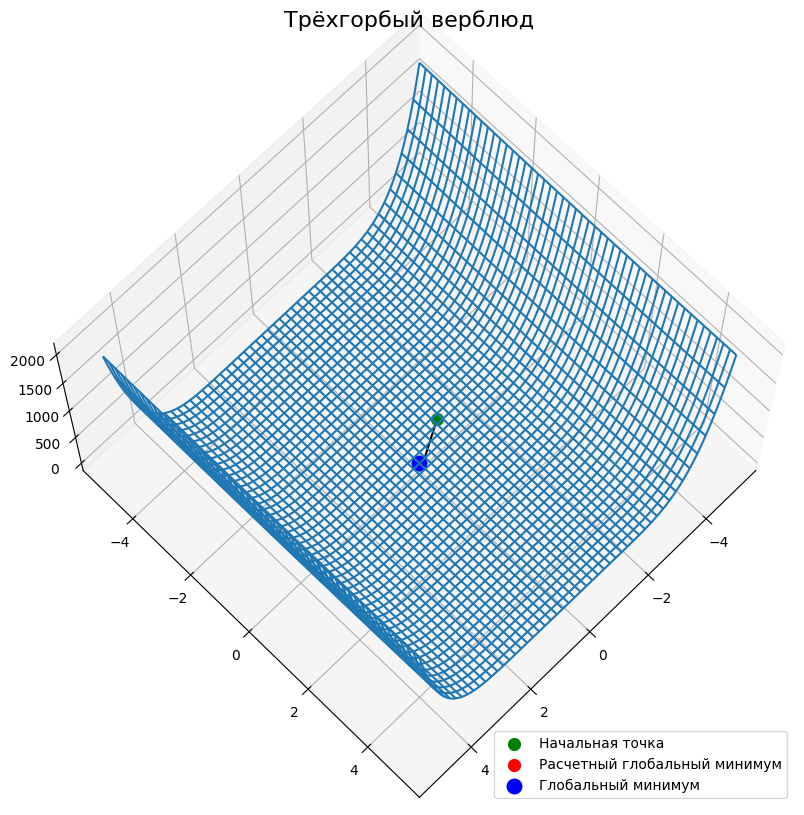

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_Adagrad(test_func_Camel, test_func_Camel_dx, test_func_Camel_dy, np.array([-1,5]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(-1,5))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(0,0))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt((p_x**2-0)+(p_y**2-0))
distances[0].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Camel, 'Трёхгорбый верблюд', history, arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 4, y0 = 4
Точка глобального минимума(расчетная): xt = 2.3470872088623373e-09 , yt = 2.3470872088623373e-09
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = -2.675288069980177e-09 

Точка глобального минимума: x=3.141592653589793, y=3.141592653589793
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  4.442882938158366


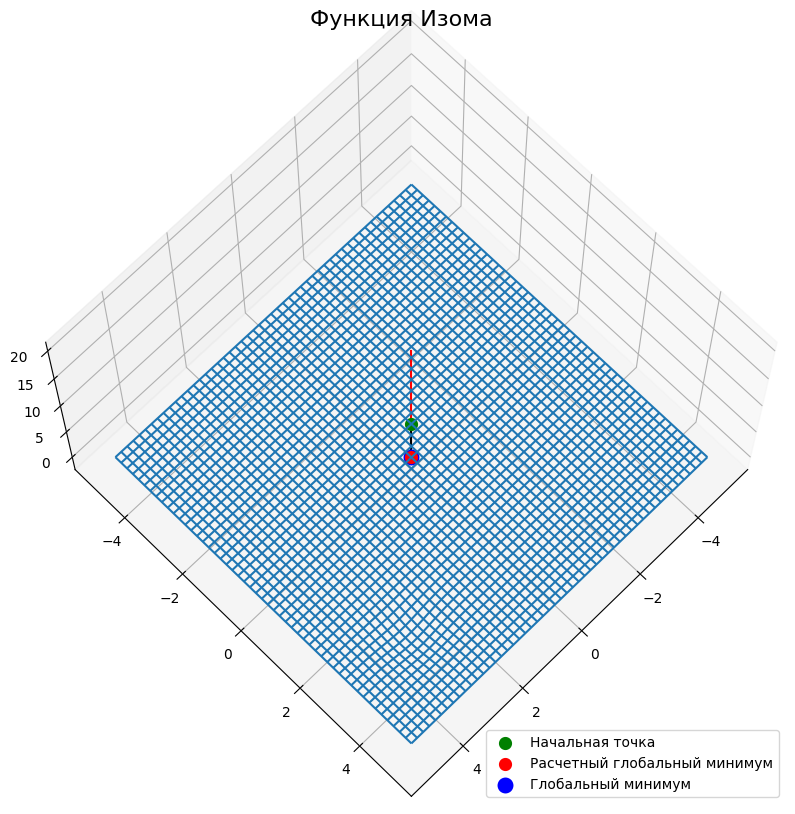

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_Adagrad(test_func_Izom, test_func_Izom_dx, test_func_Izom_dy, np.array([4,4]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(4,4))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(np.pi,np.pi))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[1].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Izom, 'Функция Изома', history,arange_x=-5, arange_y=5, arange_step=0.01)

Градиентный спуск
Начальная точка: x0 = 3, y0 = -1
Точка глобального минимума(расчетная): xt = 0.008503805645170483 , yt = -1.8343386101366716e-05
Значение функции в точке глобального минимума (расчет.): f(xt,yt) = 7.248865621782198 

Точка глобального минимума: x=3, y=0.5
Значение функции в точке глобального минимума: f(x,y) = 0
Расстояние от расчетной точки до глобального минимума:  4.4428747998488305


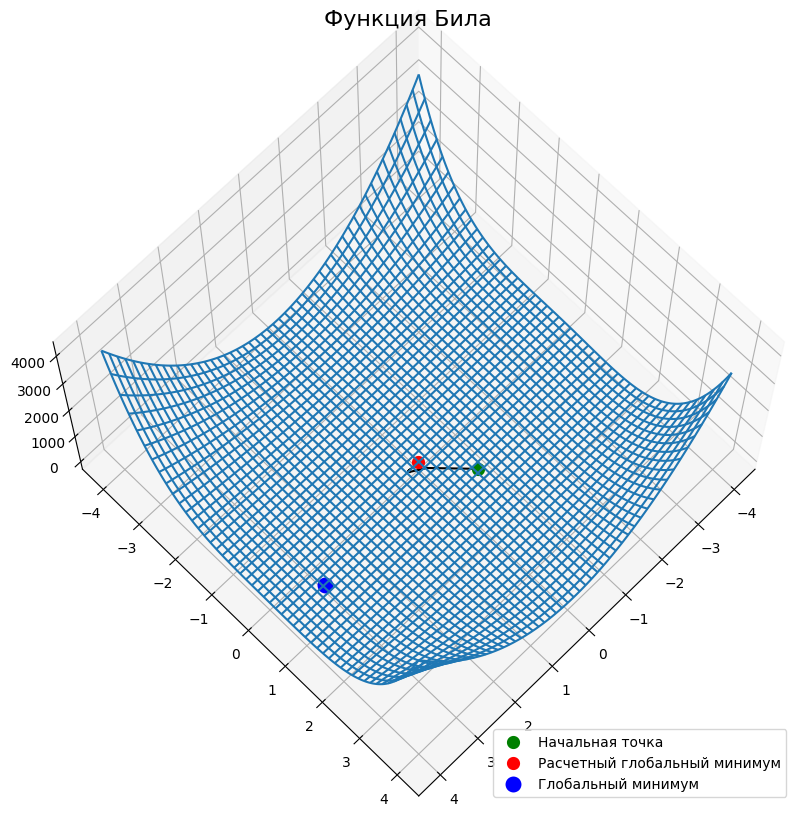

In [ ]:
history = list()
p_x,p_y,p_z = my_gd_Adagrad(test_func_Bil, test_func_Bil_dx, test_func_Bil_dy, np.array([3, -1]))
print("Градиентный спуск")
print("Начальная точка: x0 = {0}, y0 = {1}".format(3,-1))
print("Точка глобального минимума(расчетная): xt =", p_x, ", yt =", p_y,)
print("Значение функции в точке глобального минимума (расчет.): f(xt,yt) = {0} \n".format(p_z))

print("Точка глобального минимума: x={0}, y={1}".format(3,0.5))
print("Значение функции в точке глобального минимума: f(x,y) = {}".format(0))

distance = np.sqrt(np.abs((p_x**2-np.pi**2)+(p_y**2-np.pi**2)))
distances[2].append(distance)
print("Расстояние от расчетной точки до глобального минимума: ", distance)
do_plot_with_gd(test_func_Bil, 'Функция Била', history, 3, 0.5, 0, arange_x=-4, arange_y=4, arange_step=0.01)

### Сравнение результативности всех методов

In [ ]:
from tabulate import tabulate

# столбцы данные
mydata = [
    ["Расстояние до расчетной точки (GD)", distances[0][0], distances[1][0], distances[2][0]],
    ["Расстояние до расчетной точки (GD+LRS)", distances[0][1], distances[1][1], distances[2][1]],
    ["Расстояние до расчетной точки (GD Momentum)", distances[0][2], distances[1][2], distances[2][2]],
    ["Расстояние до расчетной точки (GD Adagrad)", distances[0][3],distances[1][3], distances[2][3]]
]

head = [" ", "Функция трёхгорбого верблюда", "Функция Изома", "Функция Била"]

print("Расстояния при T=10000 итераций\n")
print(tabulate(mydata, headers=head, tablefmt="grid"))

Расстояния при T=10000 итераций

+---------------------------------------------+--------------------------------+-----------------+----------------+
|                                             |   Функция трёхгорбого верблюда |   Функция Изома |   Функция Била |
+=============================================+================================+=================+================+
| Расстояние до расчетной точки (GD)          |                        1.95382 |     2.88944e-06 |        3.46422 |
+---------------------------------------------+--------------------------------+-----------------+----------------+
| Расстояние до расчетной точки (GD+LRS)      |                        3.00458 |     3.01471     |        3.70484 |
+---------------------------------------------+--------------------------------+-----------------+----------------+
| Расстояние до расчетной точки (GD Momentum) |                        0       |     4.44288     |        4.44288 |
+--------------------------------------